# Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")


Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [4]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="model-inspection", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection already exists. No changes made.


In [6]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="model-inspection", config_suffix="testCaseE3R")
print_config(loaded_config)

notebook: 
  version: testCaseE3R
  name: model-inspection
  compatible_notebooks: ['model-inspection-1']
  desc: Monitor the behaviour of 1-regulation feedback system 

exp: 
  spec: 
    n_layers: 2
    n_cascades: 3
    n_regs: 3
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: []
      target_all: True
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.5, 1.5]
    param_mul_range: [0.99, 1.01]
  simulation: 
    start: 0
    stop: 1000
    step: 100


# Run

In [7]:
from models.Specs.ModelSpec3 import ModelSpec3

notebook_config = loaded_config["notebook"]
exp_config = loaded_config["exp"]
spec_config = exp_config['spec']
n_layers = spec_config['n_layers']
new_spec = ModelSpec3(num_intermediate_layers=n_layers)


In [8]:
import logging
from models.Specs.Drug import Drug
logging.basicConfig(level=logging.INFO)


drug_config = spec_config['drug']
drug_name = drug_config['name']
drug_start = drug_config['start']
drug_dose = drug_config['dose']
drug_regulations = drug_config['regulations']

n_cascades = spec_config["n_cascades"]
n_regs = spec_config["n_regs"]
seed = spec_config["gen_seed"]

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

# check if target_all exists in drug_config, if not set to False
drug_target_all = drug_config.get('target_all', False)

if drug_target_all:
    # If the drug targets all receptors, we don't need to add specific regulations
    for n in range(n_cascades):
        target = f'R{n+1}' # assuming receptors are named R1, R2, ..., Rn
        new_drug.add_regulation(target, 'down') # assuming the type is 'down' for all
else: 
    for regs in drug_regulations:
        target, type = regs[0], regs[1]
        new_drug.add_regulation(target, type)

new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [9]:
param_gen_config = exp_config['parameter_generation']
specie_range = param_gen_config['ic_range']
param_range = param_gen_config['param_range']
param_mul_range = param_gen_config['param_mul_range']
builder = new_spec.generate_network('test', specie_range, param_range, param_mul_range, seed)

In [10]:
print(builder.get_antimony_model())

model test

J0: R1a -> R1; (J0_Vmax+D*J0_Kw0)*R1a/(J0_Km + R1a)
J1: R1 -> R1a; J1_Vmax*R1/(J1_Km + R1)
J2: R2a -> R2; (J2_Vmax+D*J2_Kw0)*R2a/(J2_Km + R2a)
J3: R2 -> R2a; J3_Vmax*R2/(J3_Km + R2)
J4: R3a -> R3; (J4_Vmax+D*J4_Kw0)*R3a/(J4_Km + R3a)
J5: R3 -> R3a; J5_Vmax*R3/(J5_Km + R3)
J6: I1_1a -> I1_1; J6_Vmax*I1_1a/(J6_Km + I1_1a)
J7: I1_1 -> I1_1a; (J7_Vmax+R1a*J7_Kw0)*I1_1/(J7_Km + I1_1)
J8: I1_2a -> I1_2; (J8_Vmax+I1_1a*J8_Kw0)*I1_2a/(J8_Km + I1_2a)
J9: I1_2 -> I1_2a; (J9_Vmax+R2a*J9_Kw0)*I1_2/(J9_Km + I1_2)
J10: I1_3a -> I1_3; J10_Vmax*I1_3a/(J10_Km + I1_3a)
J11: I1_3 -> I1_3a; (J11_Vmax+R3a*J11_Kw0)*I1_3/(J11_Km + I1_3)
J12: I2_1a -> I2_1; J12_Vmax*I2_1a/(J12_Km + I2_1a)
J13: I2_1 -> I2_1a; (J13_Vmax+I1_1a*J13_Kw0+R1a*J13_Kw1)*I2_1/(J13_Km + I2_1)
J14: I2_2a -> I2_2; (J14_Vmax+R1a*J14_Kw0)*I2_2a/(J14_Km + I2_2a)
J15: I2_2 -> I2_2a; (J15_Vmax+I1_2a*J15_Kw0)*I2_2/(J15_Km + I2_2)
J16: I2_3a -> I2_3; J16_Vmax*I2_3a/(J16_Km + I2_3a)
J17: I2_3 -> I2_3a; (J17_Vmax+I1_3a*J17_Kw0)*I2_3/(J

In [50]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver
from models.utils.config_manager import save_data
sim_config = exp_config['simulation']
sim_start = sim_config['start']
sim_stop = sim_config['stop']
sim_step = sim_config['step']
solver = RoadrunnerSolver()
solver.compile(builder.get_sbml_model())
res = solver.simulate(sim_start, sim_stop, sim_step)

save_data(notebook_config, res, "simulation_data")

save_data(notebook_config, res, "simulation_data", "csv", verbose=1)

Data saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\data\E10R10_simulation_data.csv


Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_simulation_plot.png


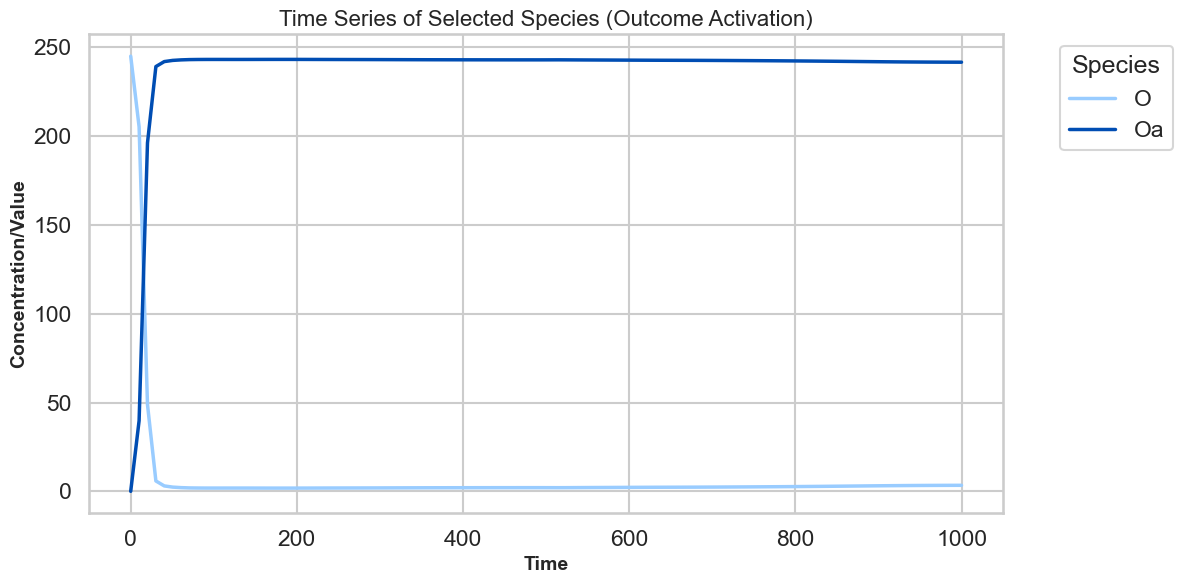

In [51]:
from visual.simulation import visualise_simulation
from models.utils.config_manager import save_figure

figure = visualise_simulation(res, activated_only=True, outcome_activation=True, show_legend=True)
save_figure(notebook_config, figure, "simulation_plot", "png", verbose=1, dpi=300)

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_network_topology.png


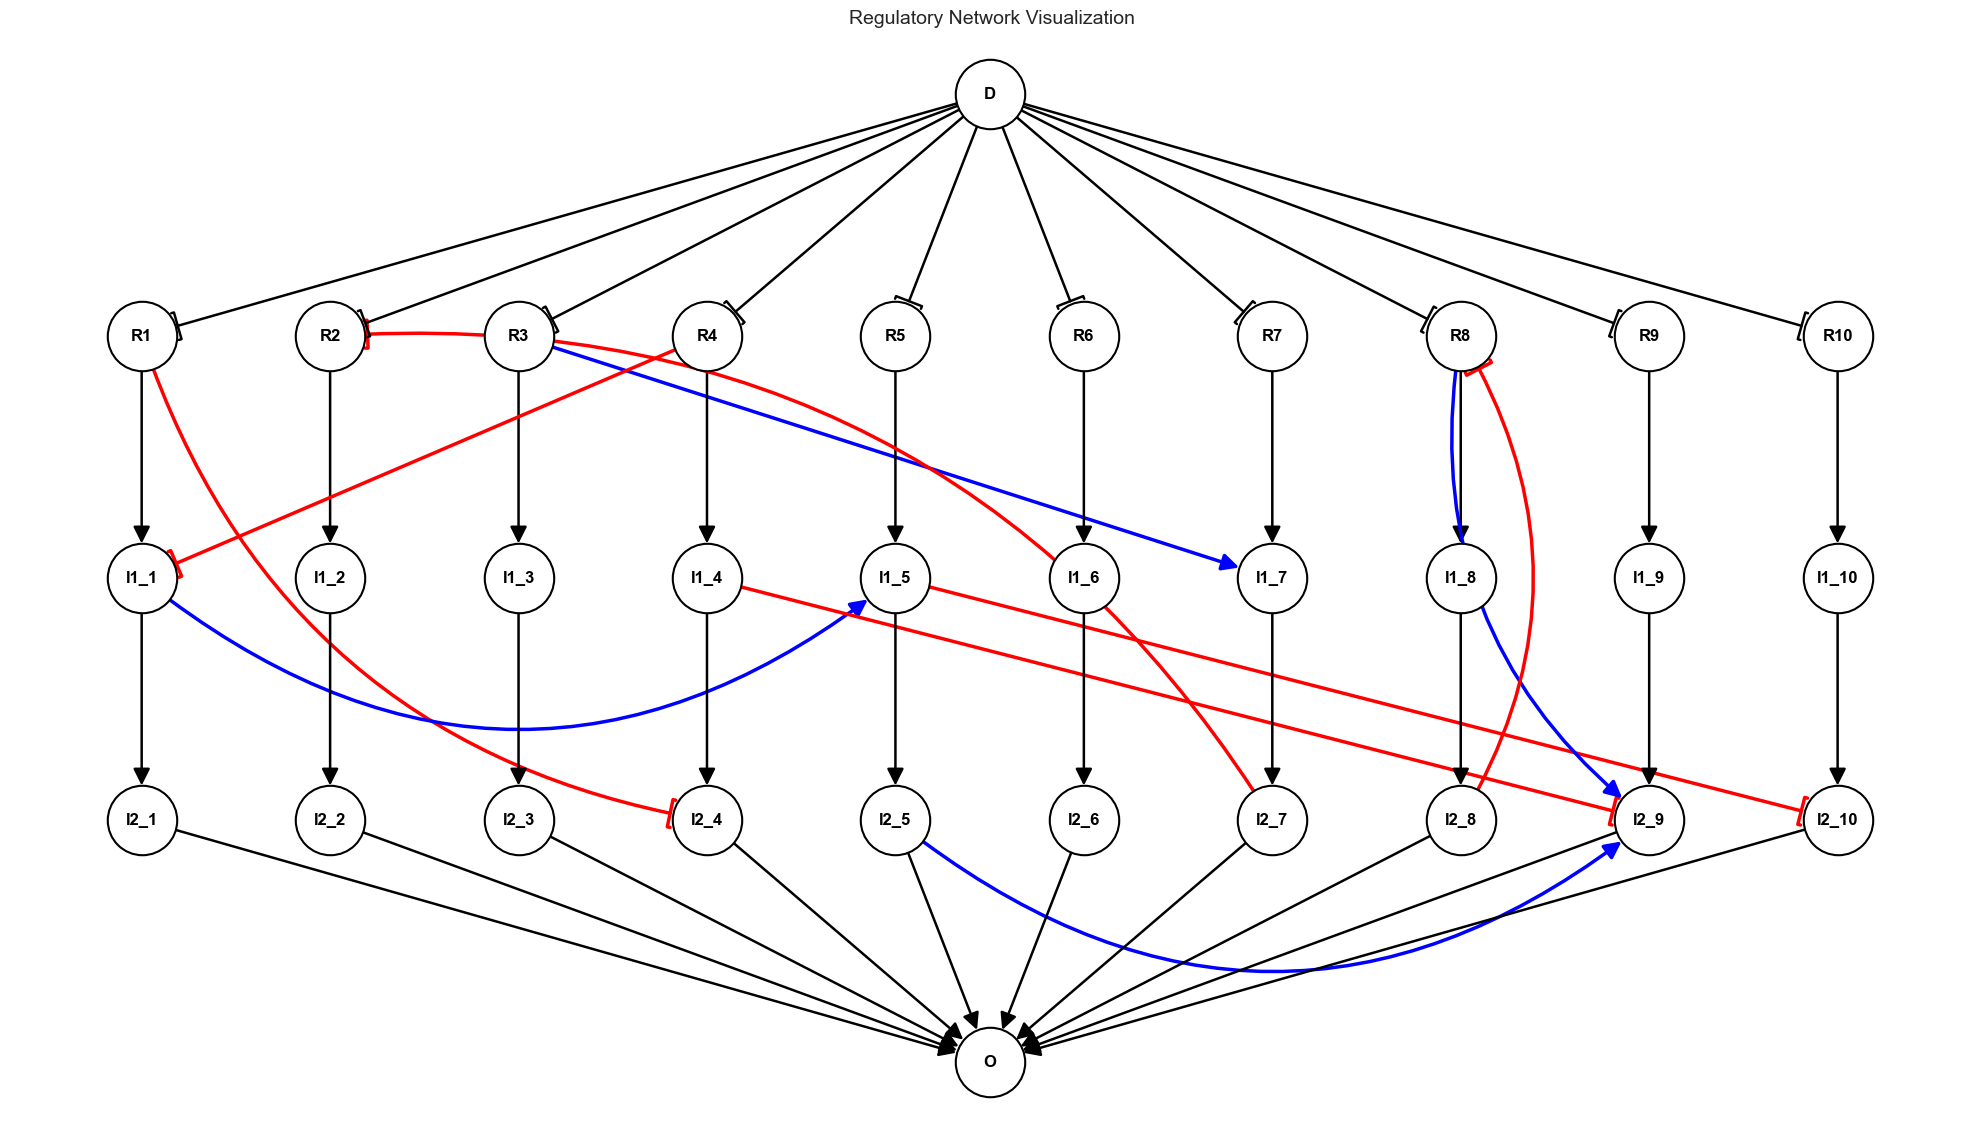

In [52]:
from visual.network_topology import visualise_network_2, create_layers

# num_intermediate_layers=2, num_cascades=3, drugs=['D']

layers = create_layers(n_layers, n_cascades, [drug_name])
regulations = new_spec.get_regulations()
feedback_regulations = new_spec.get_feedback_regulations()
figure = visualise_network_2(layers, regulations, feedback_regulations=feedback_regulations)
save_figure(notebook_config, figure, "network_topology", "png", verbose=1, dpi=300)

In [53]:
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze
import numpy as np

# Define the problem for Morris method
species = builder.get_state_variables()  # assuming builder has a method to get species names
param_names = [s for s in species if s != 'Oa']  # exclude target output
# only include 'a' species
param_names = [s for s in param_names if s.endswith('a')]

# print(specie_range)  # [200, 1000]
# bounds need to be exactly specie_range but duplicated for each parameter
bounds = [specie_range for _ in param_names]

problem = {
    'num_vars': len(param_names),
    'names': param_names,
    'bounds': bounds
}

# Generate samples
param_values = morris_sample.sample(problem, N=100, num_levels=4, optimal_trajectories=None, seed=seed)

# Run model for each sample
def run_model(params):
    # Set species initial conditions
    solver.set_state_values(dict(zip(param_names, params)))
    sim = solver.simulate(sim_start, sim_stop, sim_step)
    # Extract Oa at final time point
    return sim['Oa'].iloc[-1]

Y = np.array([run_model(params) for params in param_values])

# Morris analysis
Si = morris_analyze.analyze(problem, param_values, Y, conf_level=0.95, print_to_console=True)


              mu   mu_star     sigma  mu_star_conf
R1a     0.018989  0.025805  0.032046      0.004853
R2a     0.003899  0.003899  0.002055      0.000406
R3a     0.008832  0.008832  0.003277      0.000662
R4a    -0.017369  0.020219  0.027346      0.005406
R5a    -0.004237  0.004237  0.004582      0.000786
R6a     0.015840  0.015840  0.005328      0.001089
R7a    -0.000206  0.000471  0.000700      0.000111
R8a     0.000542  0.000542  0.000222      0.000038
R9a     0.000102  0.000102  0.000088      0.000018
R10a    0.049171  0.049171  0.041095      0.007669
I1_1a   0.019506  0.022762  0.043461      0.008388
I1_2a   0.003694  0.003694  0.001711      0.000350
I1_3a   0.088333  0.088333  0.027257      0.005047
I1_4a   0.003249  0.003249  0.000920      0.000159
I1_5a  -0.257050  0.257050  0.193996      0.039653
I1_6a   0.063301  0.063301  0.023617      0.005208
I1_7a  -0.007408  0.007408  0.004377      0.000784
I1_8a   0.001005  0.001005  0.000355      0.000059
I1_9a   0.000370  0.000370  0.0

In [54]:
save_data(notebook_config, Si, "morris_analysis", "pkl", verbose=1)

Data saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\data\E10R10_morris_analysis.pkl


Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_morris_sensitivity_analysis.png


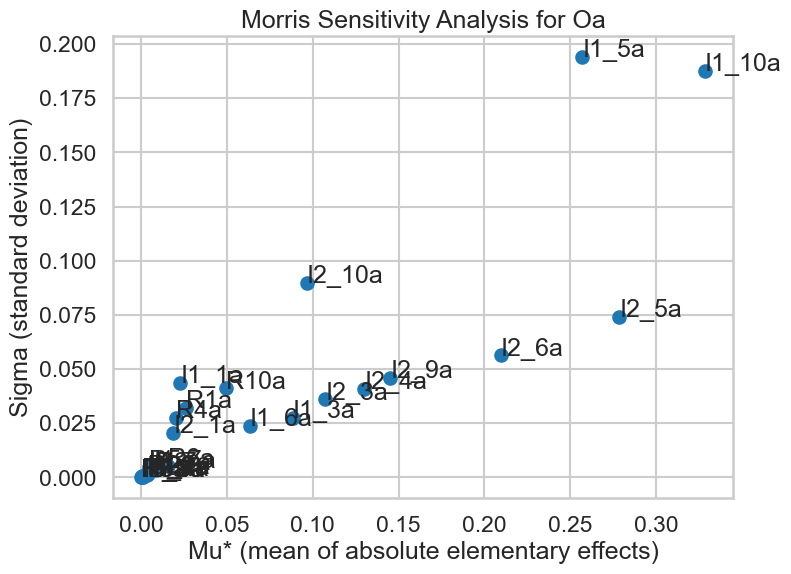

In [55]:

# Display results
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')
# set font to arial 
plt.rcParams['font.family'] = 'Arial'



mu_star = Si['mu_star']
sigma = Si['sigma']

plt.figure(figsize=(8, 6))
plt.scatter(mu_star, sigma)
for i, name in enumerate(param_names):
    plt.text(mu_star[i], sigma[i], name)
plt.xlabel('Mu* (mean of absolute elementary effects)')
plt.ylabel('Sigma (standard deviation)')
plt.title('Morris Sensitivity Analysis for Oa')
plt.grid(True)

save_figure(notebook_config, plt.gcf(), "morris_sensitivity_analysis", "png", verbose=1, dpi=300)
plt.show()

In [56]:
from models.SyntheticGen import generate_feature_data_v3

initial_values = builder.get_state_variables()
# exclude all activated species from initial_values
initial_values = {k: v for k, v in initial_values.items() if not k.endswith('a')}
# exclude 'O' and 'Oa' from perturbation
initial_values = {k: v for k, v in initial_values.items() if k not in ['O', 'Oa']}

feature_data = generate_feature_data_v3(new_spec, initial_values, 'lhs', {'min': 200, 'max': 1000}, 500, seed)

In [57]:
from models.SyntheticGen import generate_target_data

sim_params = {
    'start': sim_start,
    'end': sim_stop,
    'points': sim_step
}

target_data, timecourse_data = generate_target_data(new_spec, solver, feature_data, sim_params, outcome_var='Oa', verbose=True)

Simulating perturbations:   0%|          | 0/500 [00:00<?, ?it/s]

Simulating perturbations: 100%|██████████| 500/500 [00:04<00:00, 100.10it/s]


Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_target_distribution.png


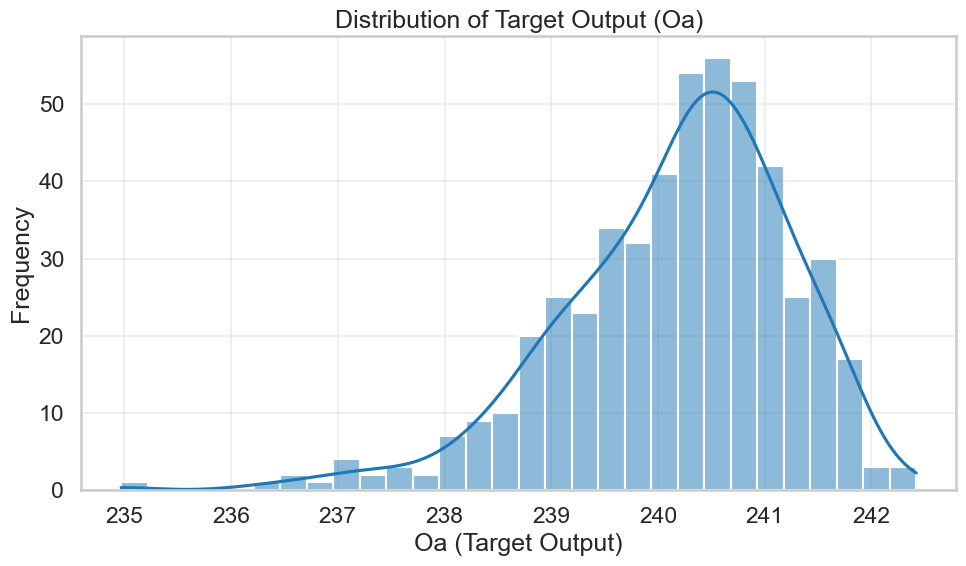

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(target_data['Oa'], bins=30, kde=True)
plt.xlabel('Oa (Target Output)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Output (Oa)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_figure(notebook_config, plt.gcf(), "target_distribution", "png", verbose=1, dpi=300)
plt.show()

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_target_timecourses.png


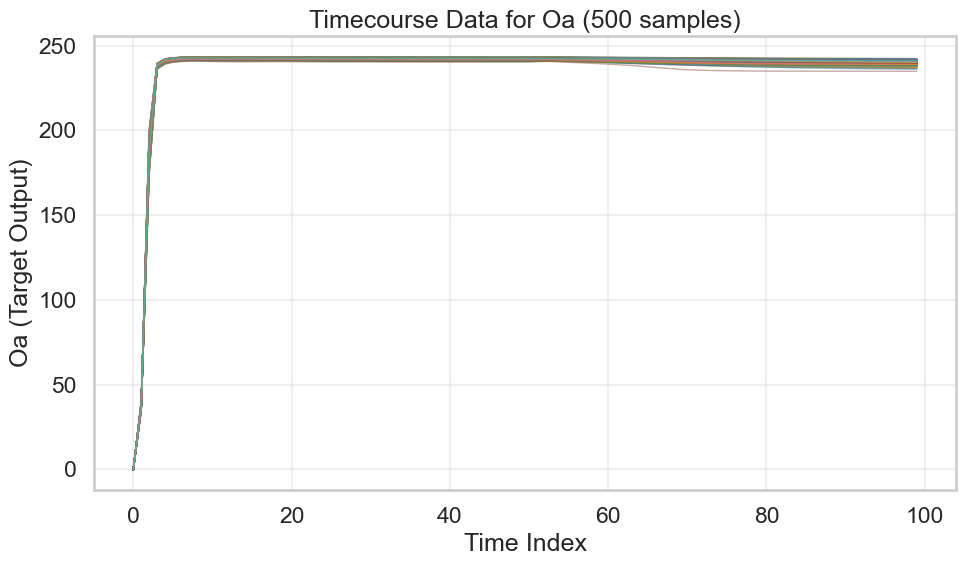

In [59]:
plt.figure(figsize=(10, 6))
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Arial'

for tc in timecourse_data:
    plt.plot(tc, alpha=0.5, linewidth=1)

plt.xlabel('Time Index')
plt.ylabel('Oa (Target Output)')
plt.title('Timecourse Data for Oa (500 samples)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_figure(notebook_config, plt.gcf(), "target_timecourses", "png", verbose=1, dpi=300)
plt.show()

Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\model-inspection\figures\E10R10_target_timecourses_after50.png


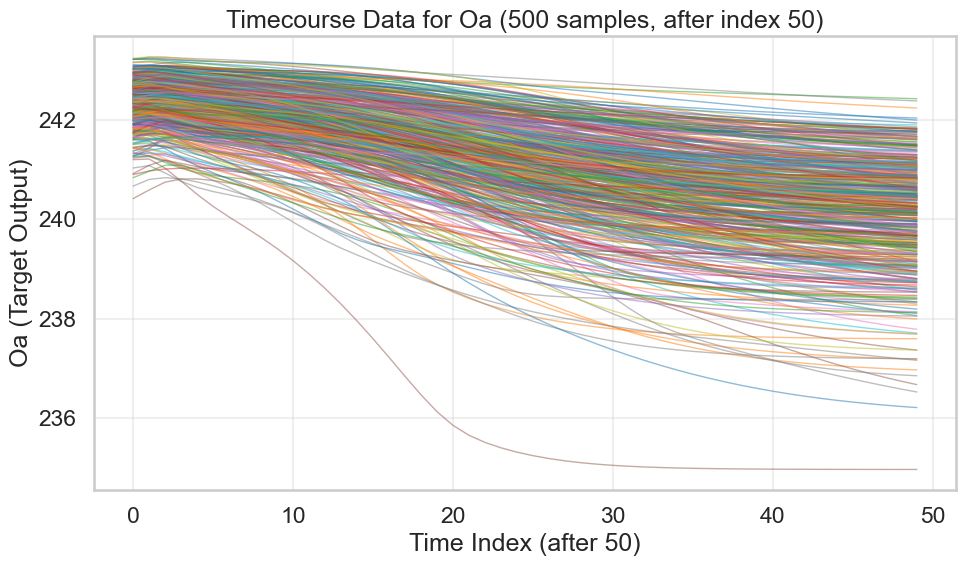

In [60]:
plt.figure(figsize=(10, 6))
sns.set_context('talk')
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Arial'

for tc in timecourse_data:
    plt.plot(tc[50:], alpha=0.5, linewidth=1)

plt.xlabel('Time Index (after 50)')
plt.ylabel('Oa (Target Output)')
plt.title('Timecourse Data for Oa (500 samples, after index 50)')
plt.grid(True, alpha=0.3)
plt.tight_layout()

save_figure(notebook_config, plt.gcf(), "target_timecourses_after50", "png", verbose=1, dpi=300)
plt.show()